# Preliminary operations and Import packages

In [ ]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
# Base
import os 
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

import pydot
import pydotplus
from pydotplus import graphviz

# Load Model

In [ ]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/Class_Weight_NoAug')

In [ ]:
# Load model
net_dcnn_112_cw = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

In [ ]:
# Load hystory and convert to dict
history = np.load('dcnn_history_112_v1.npy', allow_pickle=True).item()

In [ ]:
net_dcnn_112_cw.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                           

# Explainable AI + Demo

**Grad-CAM class activation visualization**

Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class.

## Functions

In [ ]:
def get_img_array(img_path, size):

    # `Load img
    img = keras.preprocessing.image.load_img(img_path, target_size=size)

    # `Trasform the img to numpy array of shape (w, h, 3)
    array = keras.preprocessing.image.img_to_array(img)

    # Add a dimension to transform the array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array = img_array / 255.0
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, target_size = (400,400))
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)

## Inference and class activation heatmap

In [ ]:
# Import and pre-process the image
# Save the last CONV-layer of the net

# Target size
img_size = (112, 112)

#Name of the last Conv Layer
last_conv_layer_name = "conv2d_7"

# The local path to our target image
img_path = "C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit/test/f12d7b12-0398-4533-8f55-8772cc434945.png"

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = img_array / 255.0 # Rescale pixel to (0,1) according to network input

In [ ]:
# Make a prediction and print the result

preds = net_dcnn_112_cw.predict(img_array, verbose=1) 

if np.argmax(preds, axis=1)==0:
    print('Predicted: COVID-19')
elif np.argmax(preds, axis=1)==1:
    print('Predicted: Normal')
else:
    print('Predicted: Pneumonia')

print('Ground truth: Pneumonia')

Predicted: Pneumonia
Ground truth: Pneumonia


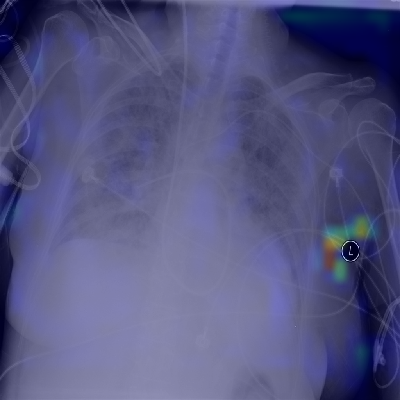

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, net_dcnn_112_cw, last_conv_layer_name)
display_gradcam(img_path, heatmap)